## Merged Data

We're getting a lot of confusion in our model between dysplasias and carcinomas and papillomas.

This notebook merges papillomas with benign tissue and dysplasias with carcinomas to create just two categories for the classification task: benign and carcinoma.

The goal is to check if there is any increased performance by merging the confusing information into sigle classes. 

In [1]:
import pandas as pd
import numpy as np
import cv2

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import matplotlib.image as mpimg
import seaborn as sns
import os

np.random.seed(2)

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

/home/che/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## DATA

patch_size = 64

folder_id = '7e716397'
base_dir = os.path.join('./data', folder_id)
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')

test_patches = pd.read_csv(os.path.join(base_dir, 'test_patches.csv'))
train_patches = pd.read_csv(os.path.join(base_dir, 'train_patches.csv'))

def read_data(data, src_dir):
    
    size = len(data)
    images = np.zeros((size, patch_size, patch_size, 3), dtype=np.float32)
    labels = np.zeros(size, dtype=np.int64)
    
    for idx, row in data.iterrows():
        img = cv2.imread(os.path.join(src_dir, row['patch_name']))
        lab = row['label_id']
        images[idx] = img
        labels[idx] = lab
        
    return images, labels


train_images, train_labels = read_data(train_patches, train_dir)
test_images, test_labels = read_data(test_patches, test_dir)
# In order to use one-hot encoding we must shift all the labels by one so we have 0-3 instead of 1-4
train_labels -= 1
test_labels -= 1

In [3]:
idxs = np.flatnonzero(test_labels)
np.random.shuffle(idxs)
added_training = int(len(idxs) / 2)
added_idxs = idxs[:added_training]
new_train_images = test_images[added_idxs]
new_train_labels = test_labels[added_idxs]

test_images = test_images[~added_idxs]
test_labels = test_labels[~added_idxs]


train_images = np.concatenate((train_images, new_train_images), axis=0)
train_labels = np.concatenate((train_labels, new_train_labels), axis=0)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2153, 64, 64, 3)
(2153,)
(172, 64, 64, 3)
(172,)


In [4]:
# set all training labels that are papillomas to benign
train_labels[train_labels == 1] = 0
test_labels[test_labels == 1] = 0

# set all training labels that are carcinoma to dysplasia, then convert them all to a new category 1
train_labels[train_labels == 3] = 2
train_labels[train_labels == 2] = 1

test_labels[test_labels == 3] = 2
test_labels[test_labels == 2] = 1

print(np.unique(train_labels), np.unique(test_labels))

[0 1] [0 1]


In [5]:
# convert to one hot encoding
train_labels_oh = to_categorical(train_labels)
test_labels_oh = to_categorical(test_labels)

train: 2153
test: 172


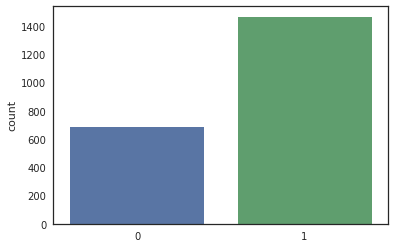

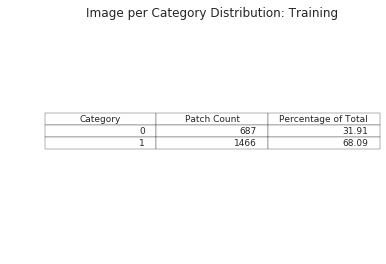

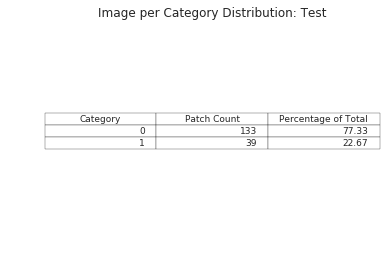

In [6]:
# Now let's inspect the results

print('train: {}'.format(len(train_images)))
print('test: {}'.format(len(test_images)))


# Let's view How the data is distributed
sns.countplot(train_labels)

def plot_patches_per_category_distribution(label_data, title=''):
    label_ids, label_counts = np.unique(label_data, return_counts=True)
    total_items = np.sum(label_counts)
    columns = ['Category', 'Patch Count', 'Percentage of Total']
    rows = label_ids
    cell_text = [
        [label_ids[0], label_counts[0], np.round((label_counts[0] / total_items)*100, 2) ],
        [label_ids[1], label_counts[1], np.round((label_counts[1] / total_items)*100, 2) ]
                ]

    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,
                         colLabels=columns, loc='center')
    plt.title('Image per Category Distribution: {}'.format(title))
    plt.show()

plot_patches_per_category_distribution(train_labels, 'Training')
plot_patches_per_category_distribution(test_labels, 'Test')

In [7]:
def simple_scale(data):
    # https://en.wikipedia.org/wiki/Feature_scaling
    return data / 255

#train_images = simple_scale(train_images)
#test_images = simple_scale(test_images)

def mean_subtraction(data):
    data -= np.mean(data)
    data /= np.std(data)
    return data
    
train_images = simple_scale(train_images)
test_images = simple_scale(test_images)

In [8]:
model = Sequential()

# padding = 'same' ; this means we are zero padding the image
# kernel_size (5,5) ; this is automatically extended by keras to the depth of the image so the filter is really (5x5x3)

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(BatchNormalization())
# output => 64x64x32

model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
# output => 64x64x64

model.add(MaxPool2D(pool_size=(2,2)))
# downsampled output => 32x32x64

#model.add(Dropout(0.25)) # randomly kill some neurons to increase generalizability 


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
# output => 64x64x64
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
#model.add(Dropout(0.25))
model.add(Dense(2, activation = "softmax"))

In [9]:
# Define the optimizer
learning_rate = 1e-4

optimizer = RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

batch_size = 128

# increase the epochs to tune up the accuracy of the model
epochs = 6

In [10]:

history = model.fit(train_images, train_labels_oh, batch_size=batch_size,
                              epochs = epochs, validation_data = (test_images,test_labels_oh),
                              verbose = 1, callbacks=[learning_rate_reduction])


Train on 2153 samples, validate on 172 samples
Epoch 1/6
2153/2153 [==============================] - 273s 127ms/step - loss: 1.5469 - acc: 0.6558 - val_loss: 1.6825 - val_acc: 0.2965
Epoch 2/6
2153/2153 [==============================] - 283s 131ms/step - loss: 0.6760 - acc: 0.7102 - val_loss: 2.3824 - val_acc: 0.2674
Epoch 3/6
2153/2153 [==============================] - 307s 143ms/step - loss: 0.5652 - acc: 0.7487 - val_loss: 0.9185 - val_acc: 0.5058
Epoch 4/6
2153/2153 [==============================] - 298s 139ms/step - loss: 0.5038 - acc: 0.7840 - val_loss: 1.6894 - val_acc: 0.3256
Epoch 5/6
2153/2153 [==============================] - 281s 130ms/step - loss: 0.4478 - acc: 0.8007 - val_loss: 1.5849 - val_acc: 0.3605
Epoch 6/6
2153/2153 [==============================] - 299s 139ms/step - loss: 0.4222 - acc: 0.8105 - val_loss: 1.5604 - val_acc: 0.3081


In [11]:
model.save('research_model_binary.h5')

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
__________

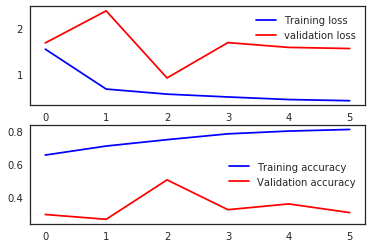

In [13]:

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

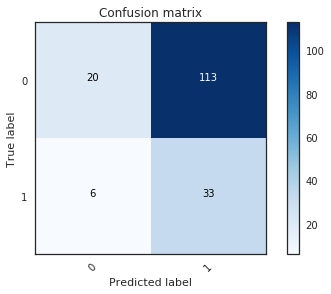

In [17]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confmat.png')

# Predict the values from the validation dataset
Y_pred = model.predict(test_images)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels_oh,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [15]:
from sklearn.metrics import recall_score, precision_score

recall = recall_score(Y_true, Y_pred_classes, average='macro')
precision = precision_score(Y_true, Y_pred_classes, average='macro')
accuracy = len(np.flatnonzero(Y_pred_classes == Y_true)) / len(Y_true)

print('accuracy: {}'.format(accuracy))
print('recall: {}\nprecision: {}'.format(recall, precision))

accuracy: 0.3081395348837209
recall: 0.4982648930017351
precision: 0.49762908324552163
